In [1]:
%matplotlib inline


# Cropped Decoding on BCIC IV 2a Dataset


Building on the `Trialwise decoding
tutorial <./plot_bcic_iv_2a_moabb_trial.html>`__, we now do more
data-efficient cropped decoding!

In Braindecode, there are two supported configurations created for
training models: trialwise decoding and cropped decoding. We will
explain this visually by comparing trialwise to cropped decoding.

<img src="file://../_static/trialwise_explanation.png">
<img src="file://../_static/cropped_explanation.png">

On the left, you see trialwise decoding:

1. A complete trial is pushed through the network.
2. The network produces a prediction.
3. The prediction is compared to the target (label) for that trial to
   compute the loss.

On the right, you see cropped decoding:

1. Instead of a complete trial, crops are pushed through the network.
2. For computational efficiency, multiple neighbouring crops are pushed
   through the network simultaneously (these neighbouring crops are
   called compute windows)
3. Therefore, the network produces multiple predictions (one per crop in
   the window)
4. The individual crop predictions are averaged before computing the
   loss function

<div class="alert alert-info"><h4>Note</h4><p>-  The network architecture implicitly defines the crop size (it is the
       receptive field size, i.e., the number of timesteps the network uses
       to make a single prediction)
    -  The window size is a user-defined hyperparameter, called
       ``input_window_samples`` in Braindecode. It mostly affects runtime
       (larger window sizes should be faster). As a rule of thumb, you can
       set it to two times the crop size.
    -  Crop size and window size together define how many predictions the
       network makes per window: ``#window−#crop+1=#predictions``</p></div>

<div class="alert alert-info"><h4>Note</h4><p>For cropped decoding, the above training setup is mathematically
    identical to sampling crops in your dataset, pushing them through the
    network and training directly on the individual crops. At the same time,
    the above training setup is much faster as it avoids redundant
    computations by using dilated convolutions, see our paper
    `Deep learning with convolutional neural networks for EEG decoding and visualization <https://arxiv.org/abs/1703.05051>`_.  # noqa: E501
    However, the two setups are only mathematically identical in case (1)
    your network does not use any padding or only left padding and
    (2) your loss function leads
    to the same gradients when using the averaged output. The first is true
    for our shallow and deep ConvNet models and the second is true for the
    log-softmax outputs and negative log likelihood loss that is typically
    used for classification in PyTorch.</p></div>

## Loading and preprocessing the dataset

Loading and preprocessing stays the same as in the `Trialwise decoding
tutorial <./plot_bcic_iv_2a_moabb_trial.html>`__.



In [2]:
from braindecode.datasets import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor, scale)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors)

/Users/milsagw1/repos/git/hololight/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 

/Users/milsagw1/repos/git/hololight/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

## Create model and compute windowing parameters

In contrast to trialwise decoding, we first have to create the model
before we can cut the dataset into windows. This is because we need to
know the receptive field of the network to know how large the window
stride should be.

We first choose the compute/input window size that will be fed to the
network during training This has to be larger than the networks
receptive field size and can otherwise be chosen for computational
efficiency (see explanations in the beginning of this tutorial). Here we
choose 1000 samples, which are 4 seconds for the 250 Hz sampling rate.




In [3]:
input_window_samples = 1000

Now we create the model. To enable it to be used in cropped decoding
efficiently, we manually set the length of the final convolution layer
to some length that makes the receptive field of the ConvNet smaller
than ``input_window_samples`` (see ``final_conv_length=30`` in the model
definition).




In [4]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
)

# Send model to GPU
if cuda:
    model.cuda()

In [5]:
model

ShallowFBCSPNet(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=transpose_time_to_spat) 
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin_exp): Expression(expression=square) 
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
  (pool_nonlin_exp): Expression(expression=safe_log) 
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 4, kernel_size=(30, 1), stride=(1, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=squeeze_final_output) 
)

And now we transform model with strides to a model that outputs dense
prediction, so we can use it to obtain predictions for all
crops.




In [6]:
from braindecode.models import to_dense_prediction_model, get_output_shape

to_dense_prediction_model(model)

In [7]:
model

ShallowFBCSPNet(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=transpose_time_to_spat) 
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin_exp): Expression(expression=square) 
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin_exp): Expression(expression=safe_log) 
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 4, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=squeeze_final_output) 
)

To know the models’ receptive field, we calculate the shape of model
output for a dummy input.




In [8]:
n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]
print( n_preds_per_input  )

467


## Cut the data into windows

In contrast to trialwise decoding, we have to supply an explicit window size and
window stride to the ``create_windows_from_events`` function.




In [9]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=True,
    preload=True
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching even

In [10]:
print( len( windows_dataset ) )
for ds, _ in zip( windows_dataset, range( 10 ) ): 
    print( ds[0].shape, ds[1], ds[2] )

576
(22, 1000) 1 [0, 625, 1625]
(22, 1000) 2 [0, 2628, 3628]
(22, 1000) 2 [0, 4546, 5546]
(22, 1000) 1 [0, 6498, 7498]
(22, 1000) 2 [0, 8506, 9506]
(22, 1000) 1 [0, 10617, 11617]
(22, 1000) 2 [0, 12534, 13534]
(22, 1000) 0 [0, 14584, 15584]
(22, 1000) 2 [0, 16515, 17515]
(22, 1000) 3 [0, 18513, 19513]


## Split the dataset

This code is the same as in trialwise decoding.




In [11]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

In [12]:
ds = dataset.datasets[0]
raw = ds.raw
annot = raw.annotations
annot.to_data_frame()

,onset,duration,description
0,1970-01-01 00:00:03.000,4.0,left_hand
1,1970-01-01 00:00:11.012,4.0,right_hand
2,1970-01-01 00:00:18.684,4.0,right_hand
3,1970-01-01 00:00:26.492,4.0,left_hand
4,1970-01-01 00:00:34.524,4.0,right_hand
5,1970-01-01 00:00:42.968,4.0,left_hand
6,1970-01-01 00:00:50.636,4.0,right_hand
7,1970-01-01 00:00:58.836,4.0,feet
8,1970-01-01 00:01:06.560,4.0,right_hand
9,1970-01-01 00:01:14.552,4.0,tongue


## Training

In difference to trialwise decoding, we now should supply
``cropped=True`` to the EEGClassifier, and ``CroppedLoss`` as the
criterion, as well as ``criterion__loss_function`` as the loss function
applied to the meaned predictions.

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we use some default parameters that we
   have found to work well for motor decoding, however we strongly
   encourage you to perform your own hyperparameter optimization using
   cross validation on your training data.</p></div>




In [13]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training import CroppedLoss

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 8

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2500        1.5868            0.2500        4.3309  0.0006  7.2390
      2            0.2500        1.3277            0.2500        4.8170  0.0006  6.7163
      3            0.2500        1.2386            0.2500        4.0857  0.0005  6.5195
      4            0.2604        1.1863            0.2569        3.1837  0.0004  6.7513
      5            0.3368        1.1363            0.2986        2.3999  0.0002  6.8971
      6            0.4097        1.1163            0.3785        1.8376  0.0001  7.0027
      7            0.4583        1.0943            0.4271        1.4567  0.0000  6.9675
      8            0.5278        1.1151            0.4965        1.2494  0.0000  6.7697


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 4, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

## Plot Results

This is again the same code as in trialwise decoding.

<div class="alert alert-info"><h4>Note</h4><p>Note that we drop further in the classification error and
    loss as in the trialwise decoding tutorial.</p></div>




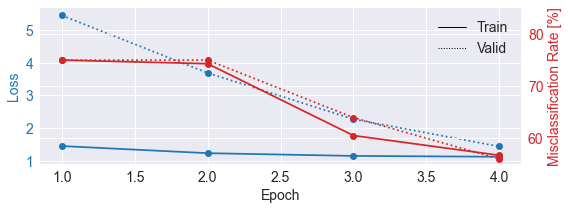

In [25]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

## Plot Confusion Matrix

Generate a confusion matrix as in https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730




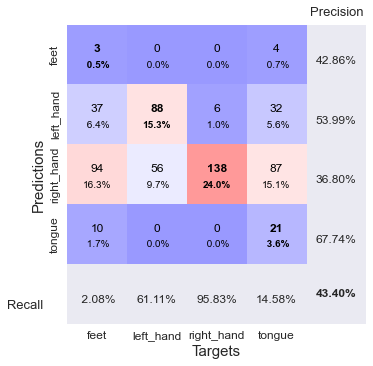

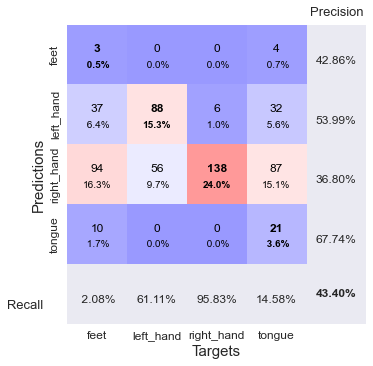

In [26]:
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = valid_set.datasets[0].windows.event_id.items()
# sort the labels by values (values are integer class labels)
labels = list(dict(sorted(list(label_dict), key=lambda kv: kv[1])).keys())

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)